In [111]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import os, sqlite3

plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125
plt.rcParams["font.family"]         = "Arial"

# Databate util function
def _connect_to_db(db_path, timeout      = 5, 
                            detect_types = 0):
    """
    :param db_path: str, the path to the database, relative to the
        current working directory, defaults to "../db/io.db"
    :param timeout: int, number of seconds the connection should wait for the
        database lock to go away before raising an exception, defaults to 5
    :param detect_types: int, type detection parameter, defaults to 0
    :return: the sqlite3 database connection object
    Connect to a database and return the connection object.
    """

    if not os.path.isfile(db_path):
        raise OSError("The database file {} was not found. Did you mean to "
                      "specify a different database file?".format(os.path.abspath(db_path)))

    conn = sqlite3.connect(db_path, timeout      = timeout, 
                                    detect_types = detect_types)

    # Enforce foreign keys (default = not enforced)
    conn.execute("PRAGMA foreign_keys=ON;")

    return conn

def _load_table(_conn, table_name):
    return pd.read_sql_query(f"SELECT * FROM {table_name}", _conn)

# Util functions
def _equalLists(lists):
    return not lists or all(lists[0] == b for b in lists[1:])

def _chainLists(lists):
    return list(itertools.chain.from_iterable(lists))

# Define color palette
def _color_palette():
    coal_color        = '#343a40'
    gas_color         = '#6c757d'
    hydro_color       = '#2a648a'
    solar_color       = '#ef9226'
    wind_color        = '#8dc0cd'
    nuclear_color     = '#8d72b3'
    other_color       = '#6ba661'
    battery_color     = '#e7c41f'# '#f07167'
    pstorage_color    = '#6a96ac' # '#000814'
    trans_color       = '#656d4a' #'#212529'
    curtailment_color = '#c94f39'

    return [battery_color, other_color, gas_color, gas_color, trans_color, hydro_color, hydro_color, pstorage_color, \
            nuclear_color, solar_color, coal_color, coal_color, coal_color, other_color, wind_color, curtailment_color]

## Define databases and scenarios for loading, processing and plotting

In [112]:
path_to_db     = r'/Users/Guille/Desktop/india_power/database/'
path_to_images = r'/Users/Guille/Desktop/india_power/images/'

# List of databases to open
db_names_  = ['india-20230727-endo.db', 'india-20230727-endo.db']

# List of scenarios set per database
scenarios_ = [[1, 14], [4, 9, 7]]

# Open Connection to databases
_conns = [_connect_to_db(path_to_db + db_name) for db_name in db_names_]

## New and Existing Capacity

* Utils for loading and processing capacity tables from the dabatabe

In [122]:
# Load project capacity table and process them from database
def _load_new_and_existing_capacity_db(table_, periods_, techs_, scenario_):
    # Grab all scenarios if not specify
    if bool(scenario_):
        scens_ = scenario_
    else:
        scens_ = np.unique(table_['scenario_id'])
        
    zones_        = np.unique(table_['load_zone'])
    all_capacity_ = np.zeros((len(scens_), len(techs_), len(periods_), len(zones_), 3))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            for period, i_period in zip(periods_, range(len(periods_))):
                for zone, i_zone in zip(zones_, range(len(zones_))):

                    # Find specific row from database 
                    idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen) & (table_['technology'] == tech) & (table_['load_zone'] == zone)
                    all_capacity_[i_scen, i_tech, i_period, i_zone, 0] = np.sum(table_.loc[idx_, 'capacity_mw'])
                    all_capacity_[i_scen, i_tech, i_period, i_zone, 1] = np.sum(table_.loc[idx_, 'new_build_mw'])
                    all_capacity_[i_scen, i_tech, i_period, i_zone, 2] = np.sum(table_.loc[idx_, 'retired_mw'])
                    
    return np.sum(all_capacity_, axis = 3)   

# Grab data from databases for plotting new and existing capacity
def _load_new_and_existing_capacity(_conns, scenarios_):

    periods_ = []
    techs_   = []
    scens_   = []
    tables_  = []
    
    # Open connection: open database and grab meta-data
    for _conn, scenario_ in zip(_conns, scenarios_):
        tables_.append(_load_table(_conn, "results_project_capacity"))
        techs_.append(np.unique(tables_[-1]['technology']).tolist())
        periods_.append(np.unique(tables_[-1]['period']).tolist())
        scens_.append(_load_table(_conn, "scenarios")['scenario_name'][scenario_].to_numpy().tolist())
        
    # Check if both databases have the same number of period otherwise rise warning
    if not _equalLists(periods_):
        print('DBs do not have same time periods')
        return [], [], [], []

    else:
        # Meta-data:
        # * Global list of periods
        periods_ = periods_[0]
        # * Gobal list of scenarios
        scens_  = _chainLists(scens_)
        # * Global list of technologies
        techs_  = np.unique(_chainLists(techs_)).tolist()
        # Data structure
        data_ = np.concatenate([_load_new_and_existing_capacity_db(table_, periods_, techs_, scenario_) 
                                for table_, scenario_ in zip(tables_, scenarios_)], axis = 0)        
        return data_, periods_, techs_, scens_

# Grab data and meta-data for plotting new and exisitng capacity graph
data_, periods_, techs_, scens_ = _load_new_and_existing_capacity(_conns, scenarios_)

* Plotting utils for new and existing capacity stack plot

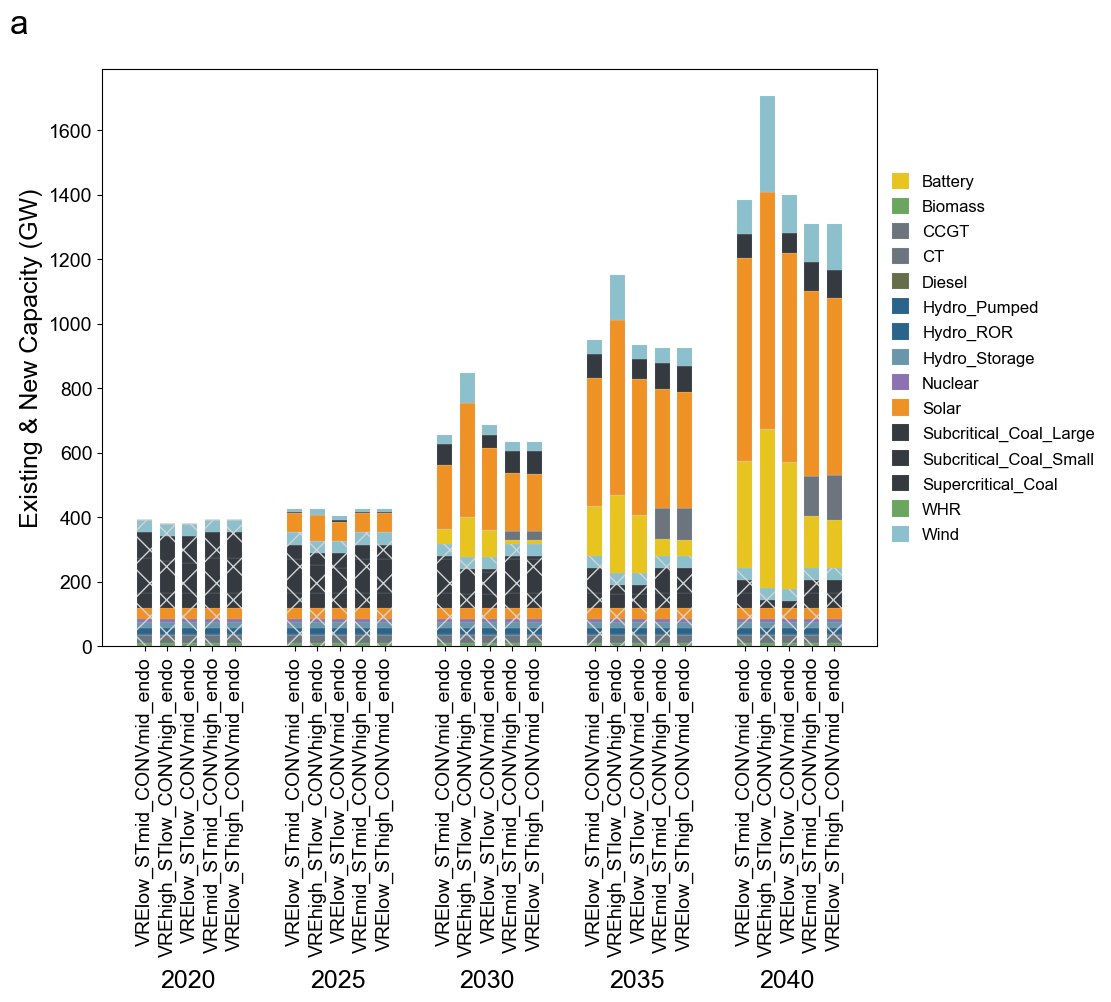

In [143]:
# Plot new and existing capacity for different scenarios
def _plot_new_and_existing_capacity(data_, periods_, techs_, scens_, colors_        = _color_palette(),
                                                                     path_to_images = '',
                                                                     save           = True, 
                                                                     file_name      = 'installed_capacity.pdf', 
                                                                     b              = 1.):
    capacity_ = data_[..., 0]
    new_      = np.cumsum(data_[..., 1], axis = -1)
    retired_  = data_[..., 2]
    width     = .1
    offset    = 0.
    units     = 1e3
    y         = 0
    x_        = np.linspace(0, len(scens_) - 1, len(scens_))

    fig = plt.figure(figsize = (10, 7.5))
    ax  = plt.subplot(111)
    
    ticks_        = []
    ticks_labels_ = []
    
    for i_scen in range(len(scens_)):
        for i_period in range(len(periods_)):
            
            existing_ = capacity_[..., 0] + retired_[..., 0] - np.cumsum(retired_, axis = -1)[..., i_period]

            if i_scen == 0:
                text = '{}'.format(periods_[i_period])
                ax.annotate(text, xy              = (x_[i_period] + (len(scens_)*width)/2. - 1.5*width, -(data_.max()/units)/b), 
                                  fontsize        = 18, 
                                  annotation_clip = False )

            for i_tech in range(len(techs_)):
                ax.bar(x_[i_period], np.absolute(existing_[i_scen, i_tech])/units, width, bottom    = offset/units, 
                                                                                          color     = colors_[i_tech], 
                                                                                          linewidth = .1, 
                                                                                          hatch     = 'x', 
                                                                                          edgecolor = 'lightgray')

                offset += existing_[i_scen, i_tech]

            for i_tech in range(len(techs_)):
                if retired_[i_scen, i_tech, i_period] < 0.:
                    print(i_scen, i_tech, i_period)

                if (i_period == 0) & (i_scen == 0):
                    ax.bar(x_[i_period], new_[i_scen, i_tech, i_period]/units, width, bottom    = offset/units, 
                                                                                      color     = colors_[i_tech], 
                                                                                      label     = techs_[i_tech],  
                                                                                      linewidth = .1, 
                                                                                      edgecolor = 'lightgray')
                else:
                    ax.bar(x_[i_period], new_[i_scen, i_tech, i_period]/units, width, bottom    = offset/units, 
                                                                                      color     = colors_[i_tech],  
                                                                                      linewidth = .1, 
                                                                                      edgecolor = 'lightgray')

                offset += new_[i_scen, i_tech, i_period]

            ticks_.append(x_[i_period]) 
            ticks_labels_.append('{}'.format(scens_[i_scen]))
            
            offset = 0.
            y     += 1

        x_ = x_ + 0.15

    
    ax.set_xticks(ticks_, ticks_labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.set_ylabel(r'Existing & New Capacity (GW)', fontsize = 18)
    
    ax.legend(loc            = 'center left', 
              bbox_to_anchor = (1, 0.5),
              frameon        = False,
              prop           = {'size': 12})
    
    letter = 'a'
    ax.annotate(letter, xy              = (-.9, 1900.),
                        fontsize        = 24, 
                        annotation_clip = False )
    
    if save: plt.savefig(path_to_images + file_name, bbox_inches = 'tight', 
                                                     dpi         = 300)
    plt.show()

# Plot new and existing capacity for different scenarios
_plot_new_and_existing_capacity(data_, periods_, techs_, scens_, path_to_images = path_to_images, 
                                                                 save           = True, 
                                                                 b              = .725)

## Green House Gas (GHG) Emissions

* Utils for loading and processing emission tables from the dabatabe

In [144]:
# Load GHG emissions table and process them from database
def _load_GHG_emissions_from_db(table_, periods_, techs_, scenario_):
    # Grab all scenarios if not specify
    if bool(scenario_):
        scens_ = scenario_
    else:
        scens_ = np.unique(table_['scenario_id'])
        
    zones_     = np.unique(table_['load_zone'])
    emissions_ = np.zeros((len(scens_), len(techs_), len(periods_), len(zones_)))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            for period, i_period in zip(periods_, range(len(periods_))):
                for zone, i_zone in zip(zones_, range(len(zones_))):
                    # Find specific row from database 
                    idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen) & (table_['technology'] == tech) & (table_['load_zone'] == zone)
                    emissions_[i_scen, i_tech, i_period, i_zone] = np.sum(table_.loc[idx_, 'carbon_emission_tons'])

    return np.sum(np.sum(emissions_, axis = -1), axis = 1)

# Grab data from databases for plotting GHG emissions
def _load_GHG_emissions(_conns, scenarios_):

    periods_ = []
    scens_   = []
    tables_  = []
    techs_   = []
    
    # Open connection: open database and grab meta-data
    for _conn, scenario_ in zip(_conns, scenarios_):
        tables_.append(_load_table(_conn, "results_project_carbon_emissions_by_technology_period"))
        techs_.append(np.unique(tables_[-1]['technology']).tolist())
        periods_.append(np.unique(tables_[-1]['period']).tolist())
        scens_.append(_load_table(_conn, "scenarios")['scenario_name'][scenario_].to_numpy().tolist())
        
    # Check if both databases have the same number of period otherwise rise warning
    if not _equalLists(periods_):
        print('DBs do not have same time periods')
        return [], [], [], []
    else:
        # Meta-data:
        # * Global list of periods
        periods_ = periods_[0]
        # * Global list of technologies
        techs_  = np.unique(_chainLists(techs_)).tolist()
        # * Gobal list of scenarios
        scens_  = _chainLists(scens_)
        # GHG emissions data structure
        data_ = np.concatenate([_load_GHG_emissions_from_db(table_, periods_, techs_, scenario_) 
                                for table_, scenario_ in zip(tables_, scenarios_)], axis = 0)        
        return data_, periods_, scens_

# Grab data and meta-data for plotting GHG emissions graph
data_, periods_, scens_ = _load_GHG_emissions(_conns, scenarios_)

* Plotting utils for GHG emissions plot

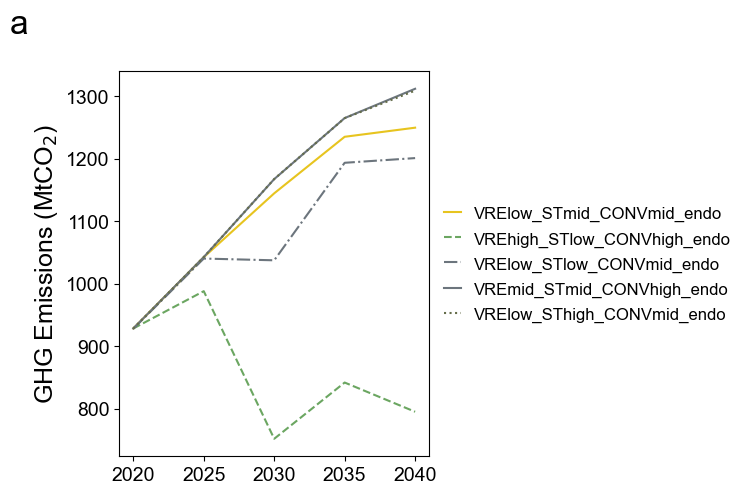

In [151]:
# Plot GHG emissions for different scenarios
def _plot_GHG_emissions(data_, periods_, scens_, colors_        = _color_palette(),
                                                 path_to_images = '', 
                                                 save           = False, 
                                                 file_name      = 'GHG_Emissions.pdf'):
    
    units  = 1e6
    x_     = np.linspace(0, data_.shape[1] - 1, data_.shape[1])
    lines_ =  ['-', '--', '-.', '-', ':']

    fig = plt.figure(figsize = (4, 5))
    ax  = plt.subplot(111)
    
    for i_scen in range(len(scens_)):
        ax.plot(x_, data_[i_scen, :]/units, color     = colors_[i_scen % len(lines_)], 
                                            linestyle = lines_[i_scen % len(lines_)], 
                                            label     = '{}'.format(scens_[i_scen]))

    ax.set_xticks(x_, periods_)

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.set_ylabel(r'GHG Emissions (MtCO$_2$)', fontsize = 18)
    
    ax.legend(loc            = 'center left', 
              bbox_to_anchor = (1, 0.5),
              frameon        = False,
              prop           = {'size': 12})

    letter = 'a'
    ax.annotate(letter, xy              = (-1.75, 1400.),
                        fontsize        = 24, 
                        annotation_clip = False )
    
    if save: plt.savefig(path_to_images + file_name, bbox_inches = 'tight', 
                                                     dpi         = 300)

    plt.show()
    
# Plot GHG emissions for different scenarios
_plot_GHG_emissions(data_, periods_, scens_, path_to_images = path_to_images, 
                                             save           = True)

## Levelized Cost Of Electricity (LCOE)

* Utils for loading and processing fuel, variable and capacity cost tables and energy target table from the dabatabe

In [152]:
# Load fuel, and operation and maintanace cost table and process data from database
def _load_variable_cost_from_db(table_, periods_, scenario_):
    # Grab all scenarios if not specify
    if bool(scenario_):
        scens_ = scenario_
    else:
        scens_ = np.unique(table_['scenario_id'])
        
    zones_ = np.unique(table_['load_zone'])
    cost_  = np.zeros((len(scens_), len(periods_), len(zones_), 2))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for period, i_period in zip(periods_, range(len(periods_))):
            for zone, i_zone in zip(zones_, range(len(zones_))):
                # Find specific row from database 
                idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen) & (table_['load_zone'] == zone)
                cost_[i_scen, i_period, i_zone, 0] = np.sum(table_.loc[idx_, 'variable_om_cost'])
                cost_[i_scen, i_period, i_zone, 1] = np.sum(table_.loc[idx_, 'fuel_cost'])
    return np.sum(cost_, axis = 2)

# Load fix capacity cost table and process data from database
def _load_capacity_cost_from_db(table_, periods_, scenario_):
    # Grab all scenarios if not specify
    if bool(scenario_):
        scens_ = scenario_
    else:
        scens_ = np.unique(table_['scenario_id'])
        
    zones_ = np.unique(table_['load_zone'])
    cost_  = np.zeros((len(scens_), len(periods_), len(zones_)))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for period, i_period in zip(periods_, range(len(periods_))):
            for zone, i_zone in zip(zones_, range(len(zones_))):
                # Find specific row from database 
                idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen) & (table_['load_zone'] == zone)
                cost_[i_scen, i_period, i_zone] = np.sum(table_.loc[idx_, 'capacity_cost'])
    return np.sum(cost_, axis = 2)

# Load energy target table and process data from database
def _load_energy_target_from_db(table_, periods_, scenario_):
    # Grab all scenarios if not specify
    if bool(scenario_):
        scens_ = scenario_
    else:
        scens_ = np.unique(table_['scenario_id'])

    energy_ = np.zeros((len(scens_), len(periods_)))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for period, i_period in zip(periods_, range(len(periods_))):
            # Find specific row from database 
            idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen)
            energy_[i_scen, i_period] = np.sum(table_.loc[idx_, 'delivered_energy_target_energy_mwh'])
    return energy_

# Grab data from databases for plotting LCOE emissions
def _load_cost_and_energy_target(_conns, scenarios_):

    periods_         = []
    scens_           = []
    tables_variable_ = []
    tables_capacity_ = []
    tables_energy_   = []
    
    # Open connection: open database and grab meta-data
    for _conn, scenario_ in zip(_conns, scenarios_):
        tables_variable_.append(_load_table(_conn, "results_project_costs_operations_agg"))
        tables_capacity_.append(_load_table(_conn, "results_project_costs_capacity_agg"))
        tables_energy_.append(_load_table(_conn, "results_system_period_energy_target"))
        periods_.append(np.unique(tables_variable_[-1]['period']).tolist())
        scens_.append(_load_table(_conn, "scenarios")['scenario_name'][scenario_].to_numpy().tolist())
        
    # Check if both databases have the same number of period otherwise rise warning
    if not _equalLists(periods_):
        print('DBs do not have same time periods')
        return [], [], [], []
    else:
        # Meta-data:
        # * Global list of periods
        periods_ = periods_[0]
        # * Gobal list of scenarios
        scens_  = _chainLists(scens_)
        # Data structure
        variable_cost_data_ = np.concatenate([_load_variable_cost_from_db(table_, periods_, scenario_) 
                                              for table_, scenario_ in zip(tables_variable_, scenarios_)], axis = 0)
        
        # Variable, fuel and fix costs data structure
        capactiy_cost_data_ = np.concatenate([_load_capacity_cost_from_db(table_, periods_, scenario_) 
                                              for table_, scenario_ in zip(tables_capacity_, scenarios_)], axis = 0)

        # Energy target data structure
        energy_data_ = np.concatenate([_load_energy_target_from_db(table_, periods_, scenario_) 
                                       for table_, scenario_ in zip(tables_energy_, scenarios_)], axis = 0)
        # Format data for plotting function
        data_ = np.concatenate([variable_cost_data_, 
                                capactiy_cost_data_[..., np.newaxis], 
                                energy_data_[..., np.newaxis]], axis = -1)
        
        return data_, periods_, scens_

# Grab data and meta-data for plotting LCOE graph
data_, periods_, scens_ = _load_cost_and_energy_target(_conns, scenarios_)

* Plotting utils for LCOE plot

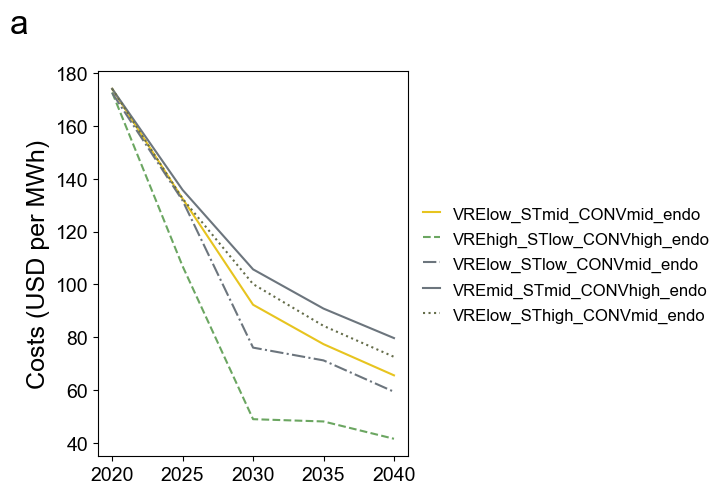

In [159]:
# Plot system cost for different scenarios
def _plot_cost_and_energy_target(data_, periods_, scens_, colors_        = _color_palette(),
                                                          path_to_images = '', 
                                                          save           = False, 
                                                          file_name      = 'Fuel_Costs.pdf'):

    fuel_cost_ = data_[..., 0]
    om_cost_   = data_[..., 1] 
    fix_cost_  = data_[..., 2]
    cost_      = fuel_cost_ + om_cost_ + fix_cost_
    energy_    = data_[..., 3]
    x_         = np.linspace(0, data_.shape[1] - 1, data_.shape[1])
    lines_     = ['-', '--', '-.', '-', ':']

    fig = plt.figure(figsize = (4, 5))
    ax  = plt.subplot(111)
    
    for i_scen in range(len(scens_)):
        ax.plot(x_, cost_[i_scen, :]/energy_[i_scen, :], color     = colors_[i_scen % len(lines_)], 
                                                         linestyle = lines_[i_scen % len(lines_)], 
                                                         label     = '{}'.format(scens_[i_scen])) 
    
    ax.set_xticks(x_, periods_)

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)

    ax.set_ylabel(r'Costs (USD per MWh)', fontsize = 18)

    ax.legend(loc            = 'center left', 
              bbox_to_anchor = (1, 0.5), 
              frameon        = False,
              prop           = {'size': 12})

    letter = 'a'
    ax.annotate(letter, xy              = (-1.45, 195.),
                        fontsize        = 24, 
                        annotation_clip = False )
    
    if save: plt.savefig(path_to_images + 'Fuel_Costs.pdf', bbox_inches = 'tight', 
                                                            dpi         = 300)

    plt.show()

# Plot system cost for different scenarios
_plot_cost_and_energy_target(data_, periods_, scens_, path_to_images = path_to_images,
                                                      save           = True)

## Energy Dispath per Technology

* Utils for loading and processing energy dispatch per technology table and energy target table from the dabatabe

In [160]:
# Load energy dispatch table and process data from database
def _load_dispatch_from_db(table_, techs_, periods_, scenario_):
    # Grab all scenarios if not specify
    if bool(scenario_):
        scens_ = scenario_
    else:
        scens_ = np.unique(table_['scenario_id'])
        
    zones_    = np.unique(table_['load_zone'])
    dispatch_ = np.zeros((len(scens_), len(techs_), len(periods_), len(zones_)))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            for period, i_period in zip(periods_, range(len(periods_))):
                for zone, i_zone in zip(zones_, range(len(zones_))):
                    # Find specific row from database 
                    idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen) & (table_['technology'] == tech) & (table_['load_zone'] == zone)         
                    dispatch_[i_scen, i_tech, i_period, i_zone] = np.sum(table_.loc[idx_, 'energy_mwh'])    
    return np.sum(dispatch_, axis = -1)

# Load curtailment from energy taret table and process data from database
def _load_curtailment_from_db(table_, periods_, scenario_):
    # Grab all scenarios if not specify
    if bool(scenario_):
        scens_ = scenario_
    else:
        scens_ = np.unique(table_['scenario_id'])

    curtail_ = np.zeros((len(scens_), len(periods_)))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for period, i_period in zip(periods_, range(len(periods_))):
            # Find specific row from database 
            idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen)
            curtail_[i_scen, i_period] = np.sum(table_.loc[idx_, 'curtailed_energy_target_energy_mwh'])
    return curtail_

# Grab data from databases for plotting LCOE emissions
def _load_energy_dispatch(_conns, scenarios_):

    periods_            = []
    techs_              = []
    scens_              = []
    tables_dispatch_    = []
    tables_curtailment_ = []
    
    # Open connection: open database and grab meta-data
    for _conn, scenario_ in zip(_conns, scenarios_):
        tables_dispatch_.append(_load_table(_conn, "results_project_dispatch_by_technology_period"))
        tables_curtailment_.append(_load_table(_conn, "results_system_period_energy_target"))
        techs_.append(np.unique(tables_dispatch_[-1]['technology']).tolist())
        periods_.append(np.unique(tables_dispatch_[-1]['period']).tolist())
        scens_.append(_load_table(_conn, "scenarios")['scenario_name'][scenario_].to_numpy().tolist())
        
    # Check if both databases have the same number of period otherwise rise warning
    if not _equalLists(periods_):
        print('DBs do not have same time periods')
        return [], [], [], []
    else:
        # Meta-data:
        # * Global list of periods
        periods_ = periods_[0]
        # * Global list of technologies
        techs_ = np.unique(_chainLists(techs_)).tolist()
        # * Gobal list of scenarios
        scens_  = _chainLists(scens_)
        # Energy dispatch per technology data structure
        dispatch_data_ = np.concatenate([_load_dispatch_from_db(table_, techs_, periods_, scenario_) 
                                              for table_, scenario_ in zip(tables_dispatch_, scenarios_)], axis = 0)
        # Energy target data structure
        curtail_data_ = - np.concatenate([_load_curtailment_from_db(table_, periods_, scenario_) 
                                          for table_, scenario_ in zip(tables_curtailment_, scenarios_)], axis = 0)
        
        # Format data for plotting function
        data_ = np.concatenate([dispatch_data_, curtail_data_[:, np.newaxis, :]], axis = 1)
        techs_.append('Curtailment')

        return data_, periods_, techs_, scens_

# Grab data and meta-data for plotting LCOE graph
data_, periods_, techs_, scens_ = _load_energy_dispatch(_conns, scenarios_)

* Plotting utils for energy dispatch per technology stack plot

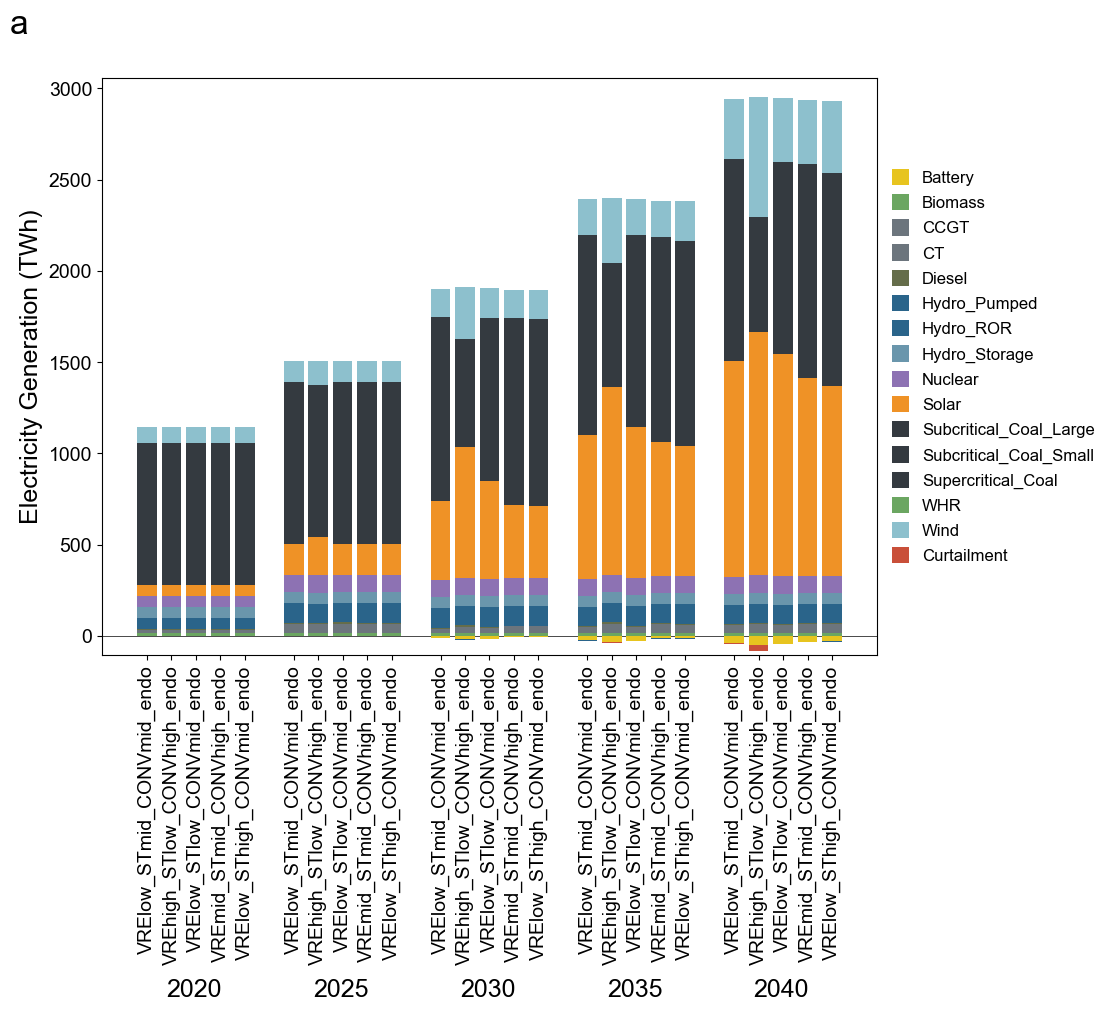

In [167]:
# Plot energy dispatch per technology for different scenarios
def _plot_dispatch(data_, periods_, techs_, scens_, colors_        = _color_palette(), 
                                                    path_to_images = '', 
                                                    save           = False, 
                                                    file_name      = 'electricity_generation.pdf', 
                                                    bias           = 1.):

    units           = 1e6
    width           = .1
    offset_positive = 0.
    offset_negative = 0.
    y               = 0
    y_min           = 0
    y_max           = 0
    x_              = np.linspace(0, len(scens_) - 1, len(scens_))*0.75

    fig = plt.figure(figsize = (10, 7.5))
    ax  = plt.subplot(111)
    
    ticks_        = []
    ticks_labels_ = []
    for i_scen in range(len(scens_)):
        for i_period in range(len(periods_)):

            if i_scen == 0:
                text = '{}'.format(periods_[i_period])
                ax.annotate(text, xy              = (x_[i_period] + (len(scens_)*width)/2. - 1.5*width, -(data_.max()/units)/bias), 
                                  fontsize        = 18, 
                                  annotation_clip = False )

            for i_tech in range(len(techs_)):

                if data_[i_scen, i_tech, i_period] > 0:
                    offset = offset_positive
                else:
                    offset = offset_negative

                if (i_period == 0) & (i_scen == 0):
                    ax.bar(x_[i_period], data_[i_scen, i_tech, i_period]/units, width, bottom = offset/units, 
                                                                                       color  = colors_[i_tech], 
                                                                                       label  = techs_[i_tech],
                                                                                       zorder = 2)
                else:
                    ax.bar(x_[i_period], data_[i_scen, i_tech, i_period]/units, width, bottom = offset/units, 
                                                                                       color  = colors_[i_tech],
                                                                                       zorder = 2)

                if data_[i_scen, i_tech, i_period] >= 0:
                    offset_positive += data_[i_scen, i_tech, i_period]
                else:
                    offset_negative += data_[i_scen, i_tech, i_period]

                # if i_tech == len(techs_) - 1:
                #     offset = 4*(i_period + 1) + len(techs_)*(i_period + 1)

            ticks_.append(x_[i_period]) 


            ticks_labels_.append('{}'.format(scens_[i_scen]))
            if offset_negative/units < y_min:
                y_min = offset_negative/units
            if offset_positive/units > y_max:
                y_max = offset_positive/units

            offset_positive = 0.
            offset_negative = 0.

            y += 1

        x_ = x_ + 0.125

    ax.axhline(0., color     = 'k',
                   linewidth = 0.5, zorder = 1)
    
    ax.set_xticks(ticks_, ticks_labels_, rotation = 90)

    ax.xaxis.set_tick_params(labelsize = 14)
    ax.yaxis.set_tick_params(labelsize = 14)
    
    ax.set_ylabel('Electricity Generation (TWh)', fontsize = 18)

    plt.ylim(y_min*1.3, y_max - y_min*1.3)

    ax.legend(loc            = 'center left', 
              bbox_to_anchor = (1, 0.5), 
              frameon        = False, 
              prop           = {'size': 12})
    
    letter = 'a'
    ax.annotate(letter, xy              = (-.7, 3300.),
                        fontsize        = 24, 
                        annotation_clip = False )
    
    if save: plt.savefig(path_to_images + file_name, bbox_inches = 'tight', 
                                                     dpi         = 300)
    plt.show()

# Plot energy dispatch per technology for different scenarios
_plot_dispatch(data_, periods_, techs_, scens_, bias           = 0.675, 
                                                path_to_images = path_to_images, 
                                                save           = True)

# Old plotting utils version

0.0 2020 Battery
0.0 2020 Biomass
0.0 2020 CCGT
0.0 2020 CT
0.0 2020 Diesel
0.0 2020 Hydro_Pumped
0.0 2020 Hydro_ROR
0.0 2020 Hydro_Storage
0.0 2020 Nuclear
0.0 2020 Solar
2500.0 2020 Subcritical_Coal_Large
25992.703999999998 2020 Subcritical_Coal_Small
0.0 2020 Supercritical_Coal
0.0 2020 WHR
0.0 2020 Wind
0.0 2025 Battery
0.0 2025 Biomass
0.0 2025 CCGT
0.0 2025 CT
0.0 2025 Diesel
0.0 2025 Hydro_Pumped
0.0 2025 Hydro_ROR
0.0 2025 Hydro_Storage
0.0 2025 Nuclear
0.0 2025 Solar
1500.0 2025 Subcritical_Coal_Large
14942.204 2025 Subcritical_Coal_Small
36515.0 2025 Supercritical_Coal
0.0 2025 WHR
0.0 2025 Wind
0.0 2030 Battery
0.0 2030 Biomass
0.0 2030 CCGT
0.0 2030 CT
0.0 2030 Diesel
0.0 2030 Hydro_Pumped
0.0 2030 Hydro_ROR
0.0 2030 Hydro_Storage
0.0 2030 Nuclear
0.0 2030 Solar
1000.0 2030 Subcritical_Coal_Large
12412.204 2030 Subcritical_Coal_Small
36515.0 2030 Supercritical_Coal
0.0 2030 WHR
0.0 2030 Wind
0.0 2035 Battery
0.0 2035 Biomass
0.0 2035 CCGT
0.0 2035 CT
0.0 2035 Diesel
0.0 203

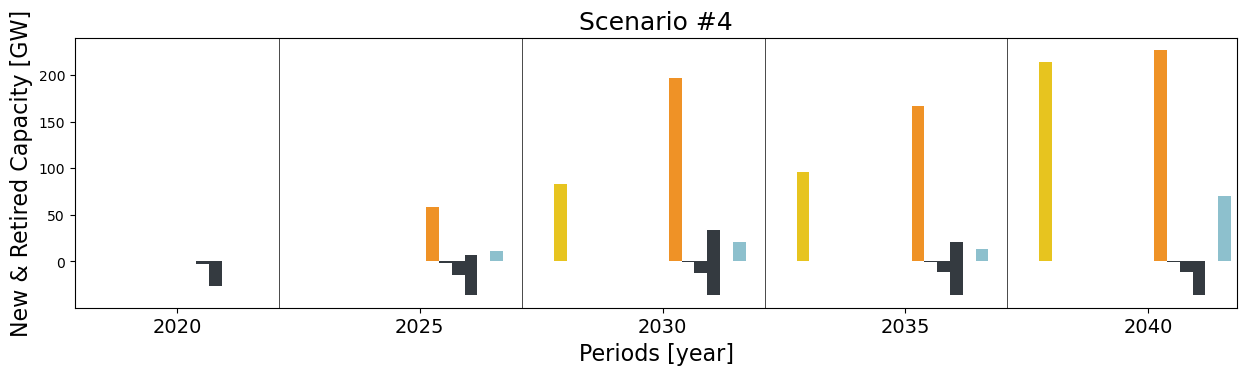

In [79]:
i_scen = 1

width  = 1.
offset = 0.
colors_ = _color_palette()
x_ = np.arange(len(techs_))
units = 1e3

plt.figure(figsize = (15, 3.5))

for i_period in range(len(periods_)):
    for i_tech in range(len(techs_)):
        print(data_[i_scen, i_tech, i_period, 2], periods_[i_period], techs_[i_tech])
        if i_period == 0:
            plt.bar(x_[i_tech] + offset, data_[i_scen, i_tech, i_period, 1]/units, width, color = colors_[i_tech], label = techs_[i_tech])
            plt.bar(x_[i_tech] + offset, - data_[i_scen, i_tech, i_period, 2]/units, width, color = colors_[i_tech])
        else:
            plt.bar(x_[i_tech] + offset, data_[i_scen, i_tech, i_period, 1]/units, width, color = colors_[i_tech])
            
            plt.bar(x_[i_tech] + offset, - data_[i_scen, i_tech, i_period, 2]/units, width, color = colors_[i_tech])
            
        if i_tech == len(techs_) - 1:
            offset = 4*(i_period + 1) + len(techs_)*(i_period + 1)


plt.axvline(16, color = 'k', lw = .5)
plt.axvline(35, color = 'k', lw = .5)
plt.axvline(54, color = 'k', lw = .5)
plt.axvline(73, color = 'k', lw = .5)

#plt.legend(ncol = 6)
plt.xticks([8, 27, 46, 65, 84], periods_, fontsize = 14)
plt.xlim(0, 91)
plt.xlabel('Periods [year]', fontsize = 16)
plt.ylabel('New & Retired Capacity [GW]', fontsize = 16)
#plt.gca().grid(which='major', axis='y', linestyle='--')
#plt.gca().grid(which='major', axis='y', linestyle='--')
#plt.gca().yaxis.set_major_locator(MultipleLocator(base = 50))
plt.title('Scenario #{}'.format(scens_[i_scen]), fontsize = 18)
#plt.savefig(path_to_images + '{}_periods_new_capacity.pdf'.format(scens_[i_scen]), bbox_inches = 'tight', dpi = 300)
plt.show()

In [74]:
def _load_new_and_existing_capacity_db(table_):

    techs_   =  np.unique(table_['technology'])
    periods_ =  np.unique(table_['period'])
    scens_   = np.unique(table_['scenario_id'])
    zones_   = np.unique(table_['load_zone'])
    print(scens_)

    Y_ = np.zeros((len(scens_), len(techs_), len(periods_), len(zones_), 3))

    for scen, i_scen in zip(scens_, range(len(scens_))):
        for tech, i_tech in zip(techs_, range(len(techs_))):
            for period, i_period in zip(periods_, range(len(periods_))):
                for zone, i_zone in zip(zones_, range(len(zones_))):

                    idx_ = (table_['period'] == period) & (table_['scenario_id'] == scen) & (table_['technology'] == tech) & (table_['load_zone'] == zone)

                    Y_[i_scen, i_tech, i_period, i_zone, 0] = np.sum(table_.loc[idx_, 'capacity_mw'])
                    Y_[i_scen, i_tech, i_period, i_zone, 1] = np.sum(table_.loc[idx_, 'new_build_mw'])
                    Y_[i_scen, i_tech, i_period, i_zone, 2] = np.sum(table_.loc[idx_, 'retired_mw'])
    return np.sum(Y_, axis = 3), techs_, periods_, scens_, zones_



# List of databases to open
db_name  = 'india-20230727-endo.db'
# Open Connection to databases
_conn = _connect_to_db(path_to_db + db_name) 
table_ = _load_table(_conn, "results_project_capacity")

data_, techs_, periods_, scens_, zones_ = _load_new_and_existing_capacity_db(table_)


[ 1  4  7  9 14]


In [264]:
X_ = _load_table(_conn, "results_project_dispatch_by_technology_period")

scens_   = np.unique(X_['scenario_id'])
techs_   = np.unique(X_['technology'])
periods_ = np.unique(X_['period'])
zones_   = np.unique(X_['load_zone'])
print(scens_)
print(techs_)
print(periods_)
print(zones_)

Y_ = np.zeros((len(scens_), len(techs_), len(periods_), len(zones_)))

for scen, i_scen in zip(scens_, range(len(scens_))):
    for tech, i_tech in zip(techs_, range(len(techs_))):
        for period, i_period in zip(periods_, range(len(periods_))):
            for zone, i_zone in zip(zones_, range(len(zones_))):

                idx_ = (X_['period'] == period) & (X_['scenario_id'] == scen) & (X_['technology'] == tech) & (X_['load_zone'] == zone)         
                
                Y_[i_scen, i_tech, i_period, i_zone] = np.sum(X_.loc[idx_, 'energy_mwh'])

[ 1  4  7  9 14]
['Battery' 'Biomass' 'CCGT' 'CT' 'Diesel' 'Hydro_Pumped' 'Hydro_ROR'
 'Hydro_Storage' 'Nuclear' 'Solar' 'Subcritical_Coal_Large'
 'Subcritical_Coal_Small' 'Supercritical_Coal' 'WHR' 'Wind']
[2020 2025 2030 2035 2040]
['Andhra_Pradesh' 'Arunachal_Pradesh' 'Assam' 'Bihar' 'Chandigarh'
 'Chhattisgarh' 'Dadra_Nagar_Haveli' 'Daman_Diu' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal_Pradesh' 'Jammu_Kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Madhya_Pradesh' 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram'
 'Nagaland' 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim'
 'Tamil_Nadu' 'Telangana' 'Tripura' 'Uttar_Pradesh' 'Uttarakhand'
 'West_Bengal']


(5, 15, 5, 34) (5, 15, 5)
-45.33817342336312 2947.9184712118404


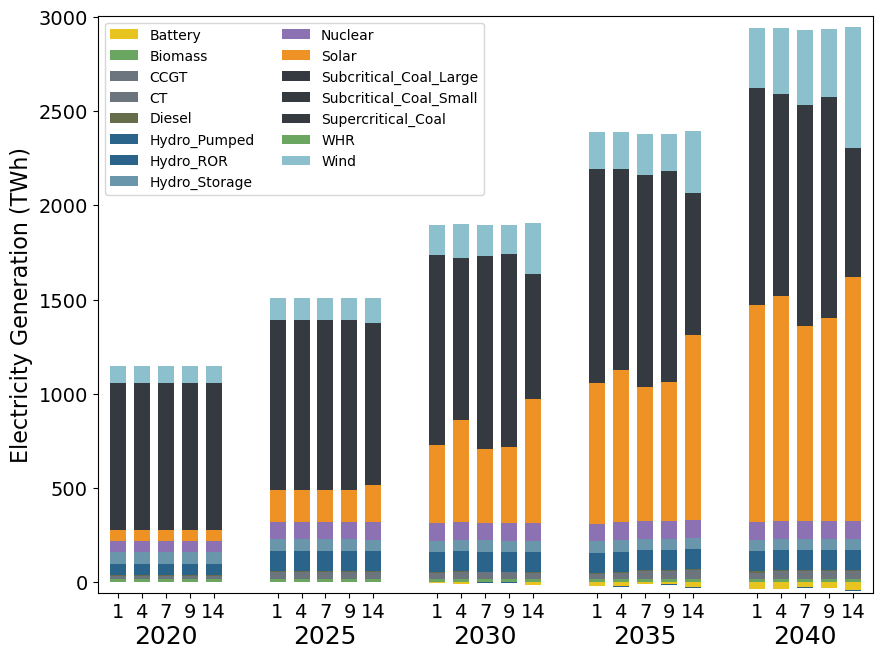

In [296]:
units = 1e6

y_ = np.sum(Y_, axis = 3)
print(Y_.shape, y_.shape)

width  = .1
offset_positive = 0.
offset_negative = 0.

x_ = np.linspace(0, len(scens_) - 1, len(scens_))
y = 0

y_min = 0
y_max = 0

plt.figure(figsize = (10, 7.5))

ticks_ = []
ticks_labels_ = []
for i_scen in range(len(scens_)):
    for i_period in range(len(periods_)):
            
        if i_scen == 0:
            plt.annotate('{}'.format(periods_[i_period]), xy = (x_[i_period] + (len(scens_)*width)/2. - 1.5*width, -(y_.max()/units)/4.), 
                                     fontsize = 18, annotation_clip = False )

        for i_tech in range(len(techs_)):


            if y_[i_scen, i_tech, i_period] > 0:
                offset = offset_positive
            else:
                offset = offset_negative
                
            if (i_period == 0) & (i_scen == 0):
                plt.bar(x_[i_period], y_[i_scen, i_tech, i_period]/units, width, bottom = offset/units, 
                                                                                 color = colors_[i_tech], 
                                                                                 label = techs_[i_tech])
            else:
                plt.bar(x_[i_period], y_[i_scen, i_tech, i_period]/units, width, bottom = offset/units, color = colors_[i_tech])

            
            if y_[i_scen, i_tech, i_period] > 0:
                offset_positive += y_[i_scen, i_tech, i_period]
            else:
                offset_negative += y_[i_scen, i_tech, i_period]

            # if i_tech == len(techs_) - 1:
            #     offset = 4*(i_period + 1) + len(techs_)*(i_period + 1)

        ticks_.append(x_[i_period]) 


        ticks_labels_.append('{}'.format(scens_[i_scen]))
        if offset_negative/units < y_min:
            y_min = offset_negative/units
        if offset_positive/units > y_max:
            y_max = offset_positive/units
            
        offset_positive = 0.
        offset_negative = 0.

        y += 1
        
    lines_.append(x_[i_period])

    x_ = x_ + 0.15

plt.xticks(ticks_, ticks_labels_, fontsize = 14)
plt.yticks(fontsize = 14)

#plt.xlabel('Periods [year]', fontsize = 16)
plt.ylabel('Electricity Generation (TWh)', fontsize = 16)
plt.xlim(ticks_[0] - .125, ticks_[-1] + .125)

print(y_min, y_max)
plt.ylim(y_min*1.3, y_max - y_min*1.3)


plt.legend(ncol = 2)
plt.savefig(path_to_images + 'electricity_generation.pdf', bbox_inches = 'tight', dpi = 300)
plt.show()

In [ ]:

x_ = np.linspace(0, Z_.shape[1] - 1, Z_.shape[1])

lines_ =  ['-', '--', '-.', '-', ':']

plt.figure(figsize = (5, 5))
for i_scen in range(len(scens_)):
    plt.plot(x_, Z_[i_scen, :]/W_[i_scen, :], color     = colors_[i_scen % len(lines_)], 
                                              linestyle = lines_[i_scen % len(lines_)], 
                                              label     = '{}'.format(scens_[i_scen])) 
    

plt.xticks(x_, periods_, fontsize = 14)
plt.yticks(fontsize = 14)

plt.ylabel(r'Costs (USD per MWh)', fontsize = 18)

plt.legend()
plt.savefig(path_to_images + 'Fuel_Costs.pdf', bbox_inches = 'tight', dpi = 300)

plt.show()

In [196]:
X_ = _load_table(_conn, "results_project_costs_operations_agg")
Y_ = _load_table(_conn, "results_project_costs_capacity_agg")


scens_   = np.unique(X_['scenario_id'])
periods_ = np.unique(X_['period'])
zones_   = np.unique(X_['load_zone'])
print(scens_)
print(techs_)
print(periods_)
print(zones_)

Z_ = np.zeros((len(scens_), len(periods_), len(zones_), 3))

for scen, i_scen in zip(scens_, range(len(scens_))):
    for period, i_period in zip(periods_, range(len(periods_))):
        for zone, i_zone in zip(zones_, range(len(zones_))):
            # Find specific row from database 
            idx_ = (X_['period'] == period) & (X_['scenario_id'] == scen) & (X_['load_zone'] == zone)       
            Z_[i_scen, i_period, i_zone, 0] = np.sum(X_.loc[idx_, 'variable_om_cost'])
            Z_[i_scen, i_period, i_zone, 1] = np.sum(X_.loc[idx_, 'fuel_cost'])
            # Find specific row from database 
            idx_ = (Y_['period'] == period) & (Y_['scenario_id'] == scen) & (Y_['load_zone'] == zone)      
            Z_[i_scen, i_period, i_zone, 2] = np.sum(Y_.loc[idx_, 'capacity_cost'])
#Z_ = np.sum(np.sum(Z_, axis = -1), axis = -1)
Z_ = np.sum(Z_, axis = 2)[..., 1]
print(Z_.shape)

[ 1  4  7  9 14]
['Battery' 'Biomass' 'CCGT' 'CT' 'Diesel' 'Hydro_Pumped' 'Hydro_ROR'
 'Hydro_Storage' 'Nuclear' 'Solar' 'Subcritical_Coal_Large'
 'Subcritical_Coal_Small' 'Supercritical_Coal' 'WHR' 'Wind']
[2020 2025 2030 2035 2040]
['Andhra_Pradesh' 'Arunachal_Pradesh' 'Assam' 'Bihar' 'Chandigarh'
 'Chhattisgarh' 'Dadra_Nagar_Haveli' 'Daman_Diu' 'Delhi' 'Goa' 'Gujarat'
 'Haryana' 'Himachal_Pradesh' 'Jammu_Kashmir' 'Jharkhand' 'Karnataka'
 'Kerala' 'Madhya_Pradesh' 'Maharashtra' 'Manipur' 'Meghalaya' 'Mizoram'
 'Nagaland' 'Odisha' 'Puducherry' 'Punjab' 'Rajasthan' 'Sikkim'
 'Tamil_Nadu' 'Telangana' 'Tripura' 'Uttar_Pradesh' 'Uttarakhand'
 'West_Bengal']
(5, 5)


In [185]:
X_ = _load_table(_conn, "results_system_period_energy_target")

scens_   = np.unique(X_['scenario_id'])
periods_ = np.unique(X_['period'])
print(scens_)
print(periods_)

W_ = np.zeros((len(scens_), len(periods_)))

for scen, i_scen in zip(scens_, range(len(scens_))):
    for period, i_period in zip(periods_, range(len(periods_))):
                
        idx_ = (X_['period'] == period) & (X_['scenario_id'] == scen)

        W_[i_scen, i_period] = np.sum(X_.loc[idx_, 'delivered_energy_target_energy_mwh'])

[ 1  4  7  9 14]
[2020 2025 2030 2035 2040]


(5, 15, 5, 34) (5, 15, 5)


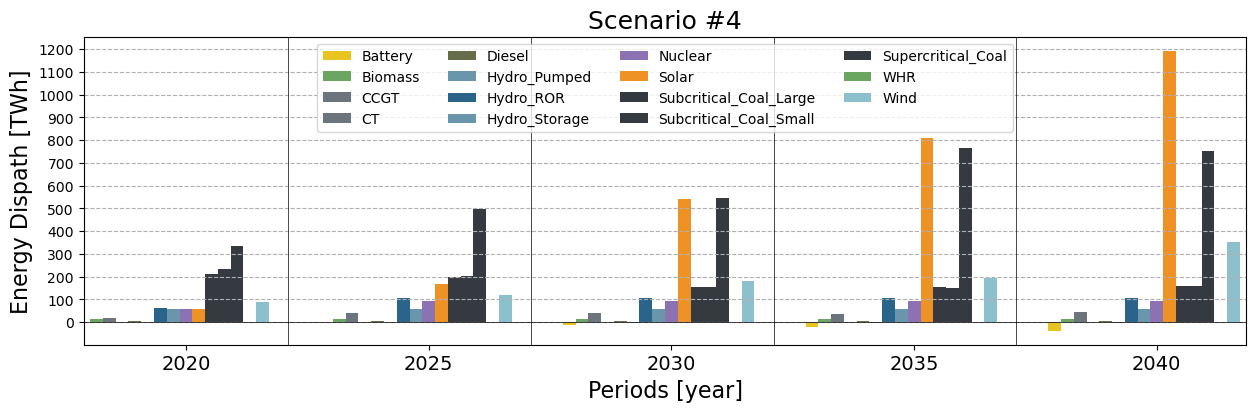

In [15]:
z_ = np.sum(Z_, axis = 3)
print(Z_.shape, z_.shape)

units = 1e6

i_scen = 1

width  = 1.
offset = 0.

x_ = np.arange(len(techs_))

plt.figure(figsize = (15, 4))
for i_period in range(z_.shape[-1]):
    for i_tech in range(len(techs_)):
        if i_period == 0:
            plt.bar(x_[i_tech] + offset, z_[i_scen, i_tech, i_period]/units, width, color = colors_[i_tech], label = techs_[i_tech])
        else:
            plt.bar(x_[i_tech] + offset, z_[i_scen, i_tech, i_period]/units, width, color = colors_[i_tech])
        if i_tech == len(techs_) - 1:
            offset = 4*(i_period + 1) + len(techs_)*(i_period + 1)
            
plt.axvline(16, color = 'k', lw = .5)
plt.axvline(35, color = 'k', lw = .5)
plt.axvline(54, color = 'k', lw = .5)
plt.axvline(73, color = 'k', lw = .5)
plt.axhline(0, color = 'k', lw = .5)

plt.legend(ncol = 4)
plt.xticks([8, 27, 46, 65, 84], periods_, fontsize = 14)
plt.xlim(0, 91)
plt.xlabel('Periods [year]', fontsize = 16)
plt.ylabel('Energy Dispath [TWh]', fontsize = 16)
#plt.gca().grid(which='major', axis='y', linestyle='--')
plt.gca().grid(which='major', axis='y', linestyle='--')
plt.gca().yaxis.set_major_locator(MultipleLocator(base = 100))
plt.title('Scenario #{}'.format(scens_[i_scen]), fontsize = 18)
plt.savefig(path_to_images + '{}_periods_energy_dispatch.pdf'.format(scens_[i_scen]), bbox_inches = 'tight', dpi = 300)
plt.show()

In [25]:
Cap_ = _load_table(_conn, "results_transmission_capacity")
print(Cap_.keys())
 
# idx_ = Cap_['scenario_id'] == 14

print(np.unique(Cap_[idx_]['tx_line']))
#print(np.unique(Cap_[idx_]['max_mw'], return_counts = True))

Index(['scenario_id', 'tx_line', 'period', 'subproblem_id', 'stage_id',
       'load_zone_from', 'load_zone_to', 'min_mw', 'max_mw'],
      dtype='object')
['Andhra_Pradesh-Karnataka' 'Andhra_Pradesh-Karnataka_new'
 'Andhra_Pradesh-Odisha' 'Andhra_Pradesh-Odisha_new'
 'Andhra_Pradesh-Tamil_Nadu' 'Andhra_Pradesh-Tamil_Nadu_new'
 'Andhra_Pradesh-Telangana' 'Andhra_Pradesh-Telangana_new'
 'Arunachal_Pradesh-Assam' 'Arunachal_Pradesh-Assam_new' 'Assam-Manipur'
 'Assam-Manipur_new' 'Assam-Meghalaya' 'Assam-Meghalaya_new'
 'Assam-Mizoram' 'Assam-Mizoram_new' 'Assam-Nagaland' 'Assam-Nagaland_new'
 'Assam-Tripura' 'Assam-Tripura_new' 'Assam-Uttar_Pradesh'
 'Assam-Uttar_Pradesh_new' 'Assam-West_Bengal' 'Assam-West_Bengal_new'
 'Bihar-Jharkhand' 'Bihar-Jharkhand_new' 'Bihar-Sikkim' 'Bihar-Sikkim_new'
 'Bihar-Uttar_Pradesh' 'Bihar-Uttar_Pradesh_new' 'Bihar-West_Bengal'
 'Bihar-West_Bengal_new' 'Chandigarh-Haryana' 'Chandigarh-Haryana_new'
 'Chandigarh-Himachal_Pradesh' 'Chandigarh-Himachal_Prades

(array([    0.        ,    50.        ,   100.        ,   154.        ,
         200.        ,   208.        ,   440.        ,   486.        ,
         517.        ,   700.        ,   917.        ,  1034.        ,
        1100.        ,  1120.        ,  1165.        ,  1200.        ,
        1250.        ,  1294.        ,  1302.22683716,  1362.        ,
        1382.        ,  1406.        ,  1434.        ,  1708.        ,
        1749.        ,  2000.        ,  2300.        ,  2500.        ,
        2912.        ,  3000.        ,  3477.        ,  3656.        ,
        3812.        ,  4355.        ,  4563.        ,  5000.        ,
        5508.        ,  5600.        ,  5750.        ,  6000.        ,
        6012.        ,  6034.        ,  6327.        ,  6394.        ,
        6594.        ,  7450.        ,  7824.        ,  8405.        ,
        8953.        ,  9075.        ,  9160.        ,  9394.        ,
        9800.        , 10205.        , 11014.        , 11177.        ,
     

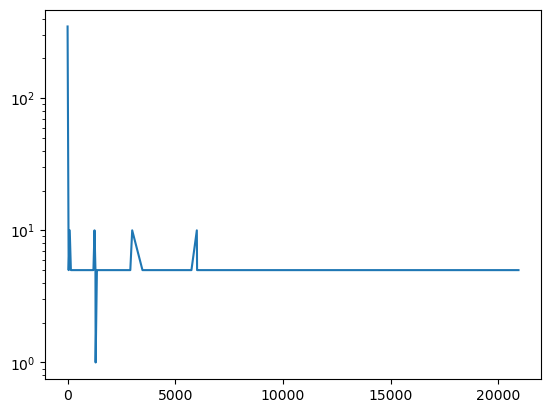

In [19]:
x_ = np.unique(Cap_[idx_]['max_mw'], return_counts = True)
print(x_)

plt.figure()
plt.plot(x_[0], x_[1])
plt.yscale('log')
plt.show()